In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <center> Data analysis

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Suppressing warnings for a cleaner notebook presentation
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = '/content/drive/MyDrive/RS_final_project/recsys2022-main/dataset/'
ORIGINAL_DATA_PATH = os.path.join(DATA_PATH, 'original_data')

## Data Loading

In [ ]:
# Loading datasets
candidate_items = pd.read_csv(os.path.join(ORIGINAL_DATA_PATH, "candidate_items.csv"))
item_features = pd.read_csv(os.path.join(ORIGINAL_DATA_PATH, "item_features.csv"))
train_sessions = pd.read_csv(os.path.join(ORIGINAL_DATA_PATH, "train_sessions.csv"), parse_dates=['date'])
test_leaderboard_sessions = pd.read_csv(os.path.join(ORIGINAL_DATA_PATH, "test_leaderboard_sessions.csv"), parse_dates=['date'])
test_final_sessions = pd.read_csv(os.path.join(ORIGINAL_DATA_PATH, "test_final_sessions.csv"), parse_dates=['date'])
train_purchases = pd.read_csv(os.path.join(ORIGINAL_DATA_PATH,"train_purchases.csv"),parse_dates=['date'], infer_datetime_format=True,header=0)

# Combining session data
sessions = pd.concat([train_sessions, test_leaderboard_sessions, test_final_sessions])
sessions['datetime'] = sessions['date'].dt.floor('min')  # Removing seconds for consistency
sessions.drop('date', axis=1, inplace=True)

# Initial data overview
print(f"Candidate Items: {candidate_items.shape}")
print(f"Item Features: {item_features.shape}")
print(f"Sessions Combined: {sessions.shape}")


Candidate Items: (4990, 1)
Item Features: (471751, 3)
Sessions Combined: (5199312, 3)


In [ ]:
sessions

,session_id,item_id,datetime
0,3,9655,2020-12-18 21:25:00
1,3,9655,2020-12-18 21:19:00
2,13,15654,2020-03-13 19:35:00
3,18,18316,2020-08-26 19:18:00
4,18,2507,2020-08-26 19:16:00
...,...,...,...
226133,4439648,7154,2021-06-14 08:03:00
226134,4439675,23067,2021-06-01 12:21:00
226135,4439868,26085,2021-06-16 22:18:00
226136,4439966,19483,2021-06-06 20:05:00


# Sales Time

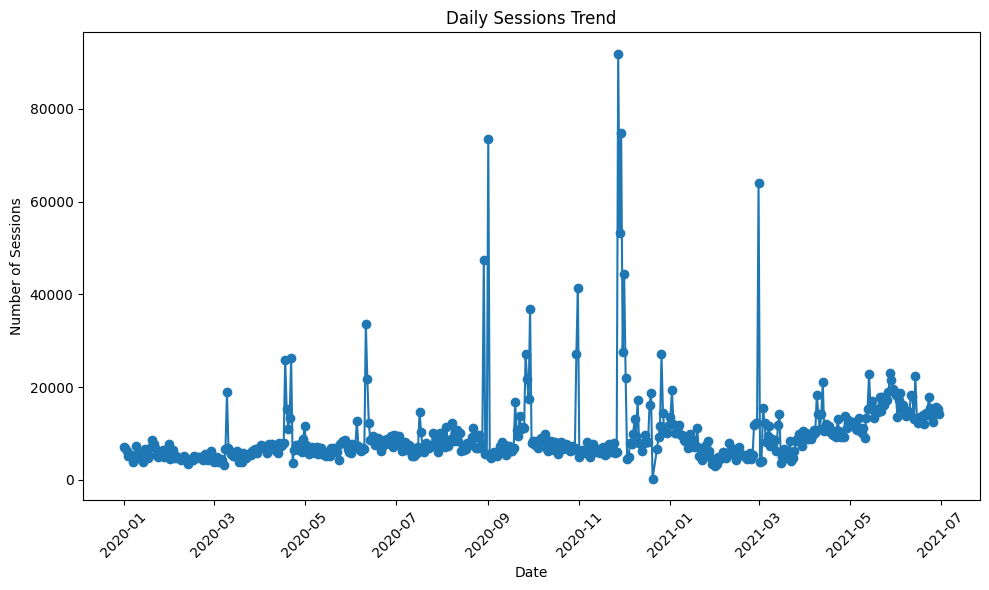

In [ ]:
# Trend of sessions over time
sessions['date'] = sessions['datetime'].dt.date
sessions_daily = sessions.groupby('date').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.plot(sessions_daily['date'], sessions_daily['count'], marker='o', linestyle='-')
plt.title('Daily Sessions Trend')
plt.xlabel('Date')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
sessions_daily.sort_values('count',ascending=False).head(10)

,date,count
330,2020-11-27,91925
332,2020-11-29,74800
243,2020-09-01,73494
422,2021-03-01,63917
331,2020-11-28,53172
240,2020-08-29,47433
334,2020-12-01,44288
303,2020-10-31,41482
271,2020-09-29,36877
161,2020-06-11,33707


The session count trends indicate a strong correlation with well-known retail events and seasonal shopping periods. The highest peaks align with Black Friday and the subsequent shopping weekend, which traditionally sees a surge in retail activity as consumers take advantage of deals. Other significant session increases correspond with back-to-school periods, the start of spring, and early holiday shopping in December. Halloween and end-of-month dates also show heightened activity, suggesting that these periods may feature promotions or specific events that drive online engagement. Lesser peaks in session counts during off-peak times like June could be attributed to mid-year sales or localized retail events. Overall, the data reflects the impact of retail cycles and consumer behavior on online session frequency.

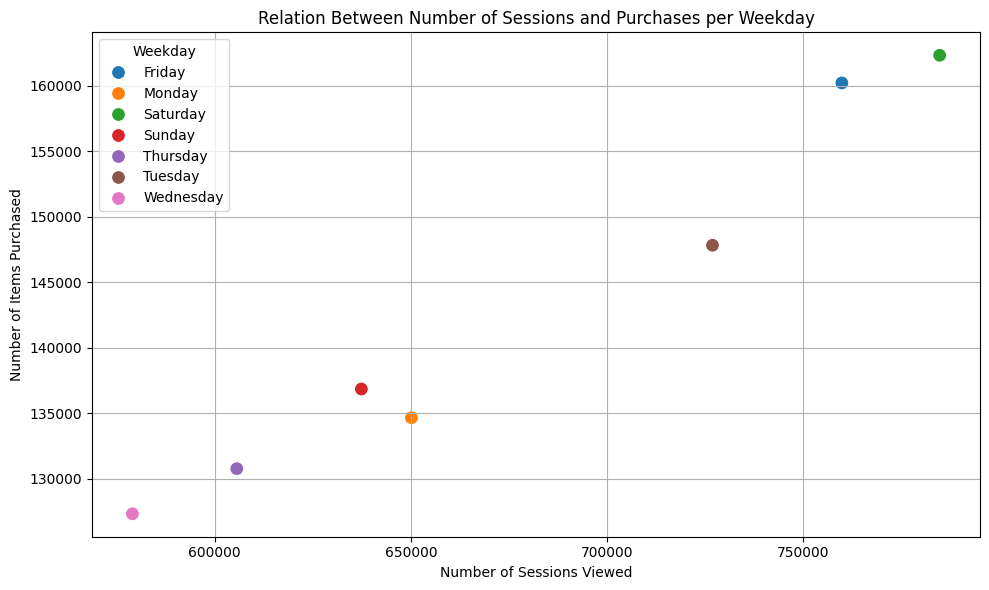

In [ ]:

train_purchases['weekday'] = train_purchases['date'].dt.day_name()
train_sessions['weekday'] = train_sessions['date'].dt.day_name()

# Group by 'weekday' and count the number of sessions and purchases.
weekday_sessions = train_sessions.groupby('weekday').size().reset_index(name='session_count')
weekday_purchases = train_purchases.groupby('weekday').size().reset_index(name='purchase_count')

# Merge the two DataFrames on 'weekday'.
merged_data = pd.merge(weekday_sessions, weekday_purchases, on='weekday')

# Plotting the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='session_count', y='purchase_count', hue='weekday', s=100)

plt.title('Relation Between Number of Sessions and Purchases per Weekday')
plt.xlabel('Number of Sessions Viewed')
plt.ylabel('Number of Items Purchased')
plt.legend(title='Weekday')
plt.grid(True)
plt.tight_layout()
plt.show()

- Weekend activity in both sessions viewed and purchases is higher than on weekdays.
- Users likely have more time to browse and shop online during weekends.
- The correlation suggests more time spent on exploring items may lead to more purchases.
- Despite higher session counts, the conversion rate on weekends needs further analysis to confirm its efficiency.
- Factors influencing weekend spikes could include free time, sales, or habitual shopping patterns.

In [ ]:
category_purchases = pd.merge(train_purchases,item_features,on='item_id')

In [ ]:
data = category_purchases

data['date'] = pd.to_datetime(data['date'])


data['day_of_week'] = data['date'].dt.day_name()

# Group the data by 'feature_category_id' and 'day_of_week' and count the occurrences
category_weekday = data.groupby(['feature_category_id', 'day_of_week']).size().reset_index(name='counts')

# Determine the top 10% popular categories
top_categories = category_weekday.groupby('feature_category_id')['counts'].sum()
top_categories = top_categories.sort_values(ascending=False)
top_percentile = top_categories.quantile(0.90)
top_categories = top_categories[top_categories >= top_percentile].index.tolist()

# Filter the data to include only the top categories
top_category_weekday = category_weekday[category_weekday['feature_category_id'].isin(top_categories)]

# Pivot the data for heatmap visualization
pivot_table = top_category_weekday.pivot("day_of_week", "feature_category_id", "counts")



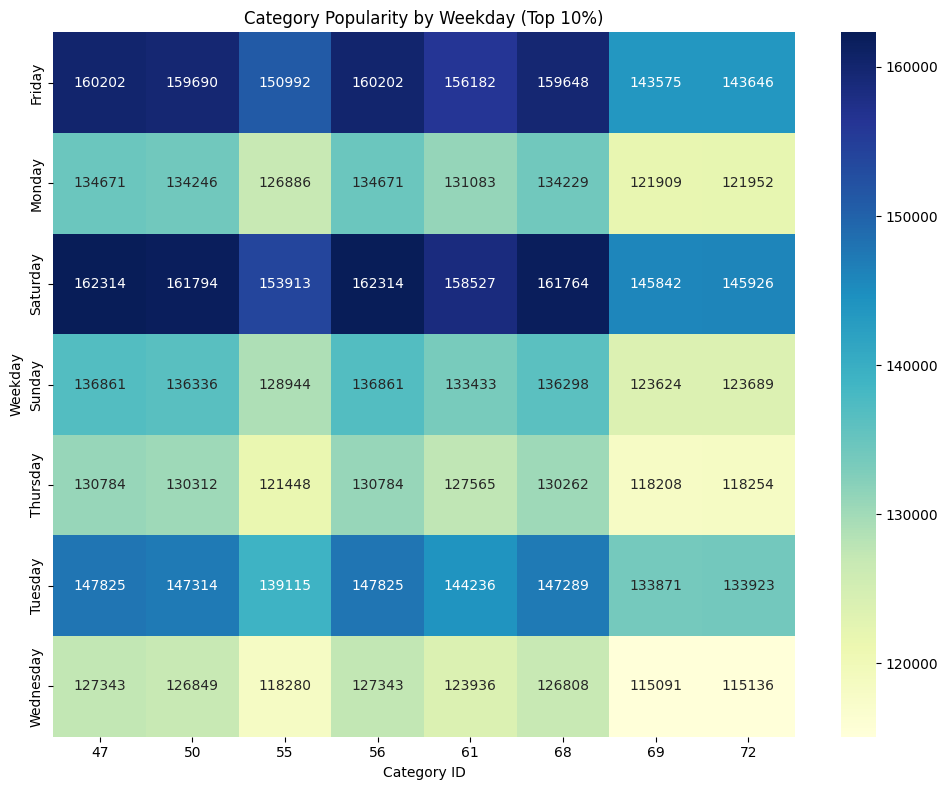

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Category Popularity by Weekday (Top 10%)')
plt.xlabel('Category ID')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()

The heatmap you provided shows a comparison of category popularity across different weekdays. Here are some of our insights:

1. **Weekday vs. Weekend Trends**: Some categories show significant variation between weekdays and weekends, which could indicate that certain products or services are preferred during leisure time or workdays. This suggests that marketing or promotion strategies could be adjusted accordingly to target users more effectively on days when they are most engaged.

2. **High-Traffic Days**: Categories tend to peak on specific days, for instance, Fridays show high popularity across several categories. This could mean that users are more active or that specific events on these days drive higher engagement. Businesses could leverage these peak times for launching new products or campaigns.

3. **Consistency Across the Week**: Some categories maintain consistent popularity throughout the week, indicating a steady demand or interest. These categories could represent essential services or evergreen content that users consistently engage with, making them reliable for steady revenue.


# Items categories

In [ ]:
it_cat_count = item_features.groupby('feature_category_id').count().reset_index().sort_values('item_id',ascending=False)
it_cat_count = it_cat_count[['feature_category_id','item_id']].rename(columns={'item_id':'items_count'}).set_index('feature_category_id')

In [ ]:

fig = px.bar(it_cat_count.reset_index(), x='feature_category_id', y='items_count', text='items_count',
             title='Top Feature Categories by Item Count')

fig.update_layout(
    xaxis_title='Feature Category ID',
    yaxis_title='Count of Items',
    xaxis={'categoryorder':'total descending'}
)

array([[<Axes: title={'center': 'items_count'}>]], dtype=object)

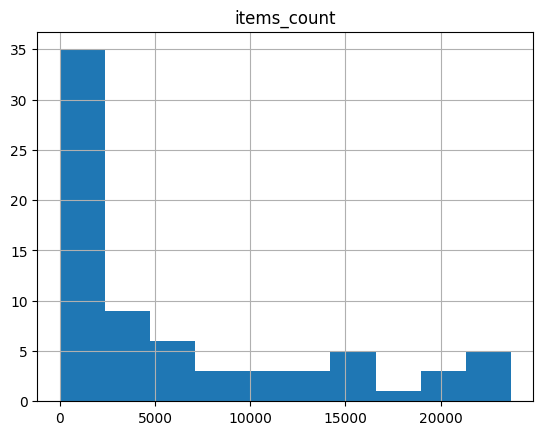

In [ ]:
it_cat_count.hist()

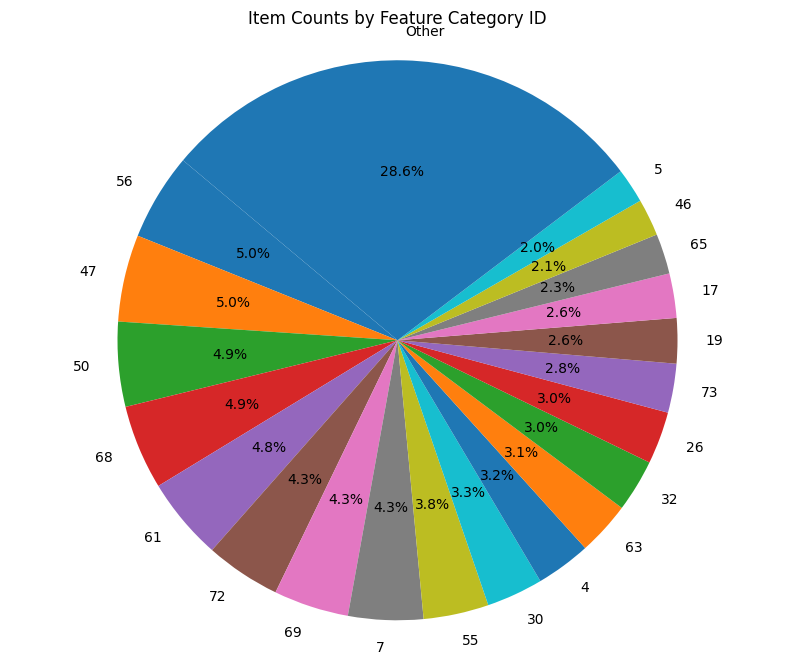

In [ ]:
df = it_cat_count.reset_index()

top_20 = df.nlargest(20, 'items_count')
other_data = {'feature_category_id': 'Other', 'items_count': df.iloc[20:]['items_count'].sum()}
top_20 = top_20.append(other_data, ignore_index=True)

plt.figure(figsize=(10, 8))
plt.pie(top_20['items_count'], labels=top_20['feature_category_id'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Item Counts by Feature Category ID')
plt.show()

- A few feature categories, particularly 56 and 47, dominate the item count, indicating their general appeal or broader classification.
- The histogram showcases a long-tail distribution, with many categories having few items and a small number having many.
- The pie chart shows a healthy diversity of categories, with the 'Other' section representing a substantial but not overwhelming portion.
- Categories 56 and 47 share the top spot for item count, suggesting they may have similar classification criteria or represent equally popular item types.
- There is a noticeable decay in item counts from the most populated categories to the least, reflecting a common retail pattern.

## Session Time by Category

In [ ]:
phurches_sessions = train_purchases.merge(sessions,on='session_id')
sessions_time = phurches_sessions.groupby("session_id").agg( {"datetime": ["min", "max"]})

In [ ]:
phurches_item_features = train_purchases.merge(item_features,on='item_id')
phurches_item_features= phurches_item_features[['session_id','date','feature_category_id']].rename(columns={'date':'session_end'})

In [ ]:
end2end_sessions = phurches_item_features.merge(sessions.head(500000),on='session_id')
end2end_sessions

,session_id,session_end,feature_category_id,item_id,datetime
0,3,2020-12-18 21:26:47.986,56,9655,2020-12-18 21:25:00
1,3,2020-12-18 21:26:47.986,56,9655,2020-12-18 21:19:00
2,3,2020-12-18 21:26:47.986,47,9655,2020-12-18 21:25:00
3,3,2020-12-18 21:26:47.986,47,9655,2020-12-18 21:19:00
4,3,2020-12-18 21:26:47.986,37,9655,2020-12-18 21:25:00
...,...,...,...,...,...
10832567,467909,2020-03-06 16:51:55.572,52,27363,2020-03-06 16:48:00
10832568,467909,2020-03-06 16:51:55.572,43,27363,2020-03-06 16:48:00
10832569,467909,2020-03-06 16:51:55.572,47,27363,2020-03-06 16:48:00
10832570,467909,2020-03-06 16:51:55.572,56,27363,2020-03-06 16:48:00


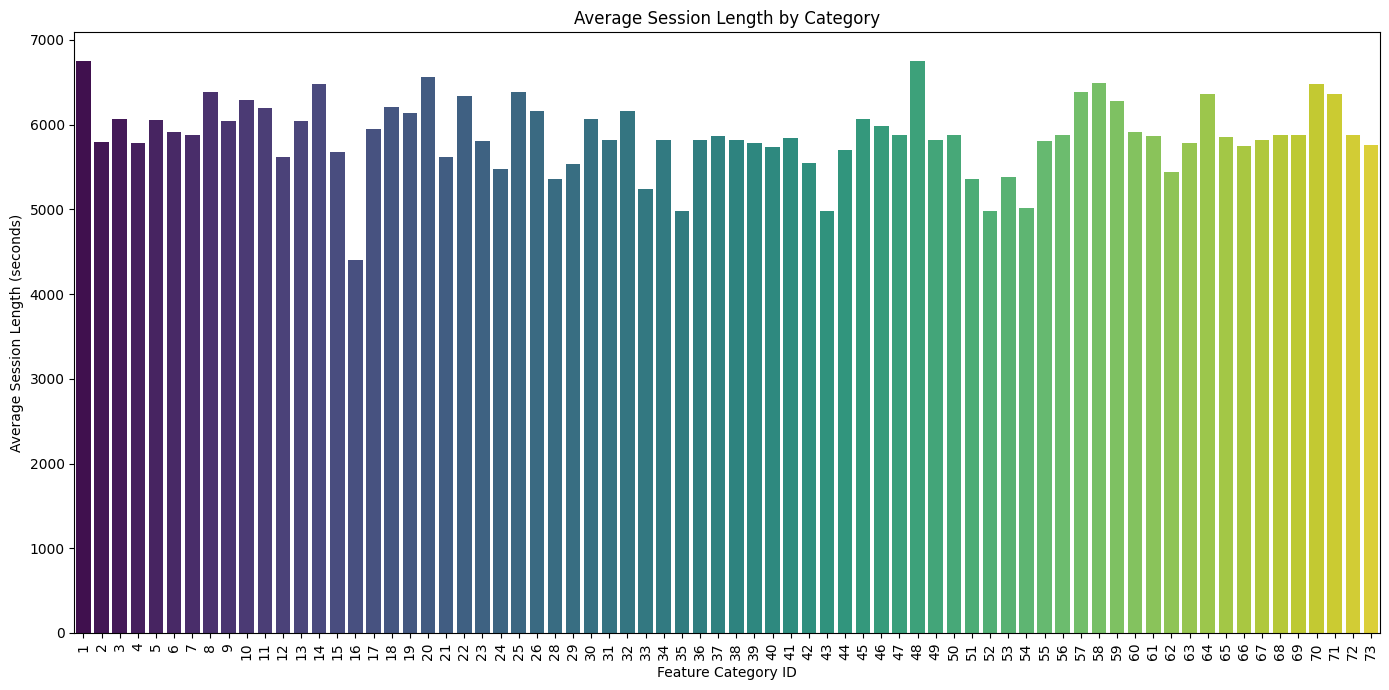

In [ ]:

end2end_sessions['session_end'] = pd.to_datetime(end2end_sessions['session_end'])
end2end_sessions['datetime'] = pd.to_datetime(end2end_sessions['datetime'])

# Group by session id and calculate their min datetime
sessions_min_time = end2end_sessions.groupby('session_id')['datetime'].min().reset_index()

# Merge this with the original dataframe to get the session length
end2end_sessions = pd.merge(end2end_sessions, sessions_min_time, on='session_id', suffixes=('', '_min'))

# Calculate the session length
end2end_sessions['session_length'] = (end2end_sessions['session_end'] - end2end_sessions['datetime_min']).dt.total_seconds()

category_avg_session_length = end2end_sessions.groupby('feature_category_id')['session_length'].mean().reset_index()
category_avg_session_length.sort_values('session_length', inplace=True)

# Plot the average session length for each category
plt.figure(figsize=(14, 7))
sns.barplot(data=category_avg_session_length, x='feature_category_id', y='session_length', palette='viridis')
plt.title('Average Session Length by Category')
plt.xlabel('Feature Category ID')
plt.ylabel('Average Session Length (seconds)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if needed
plt.tight_layout()
plt.show()

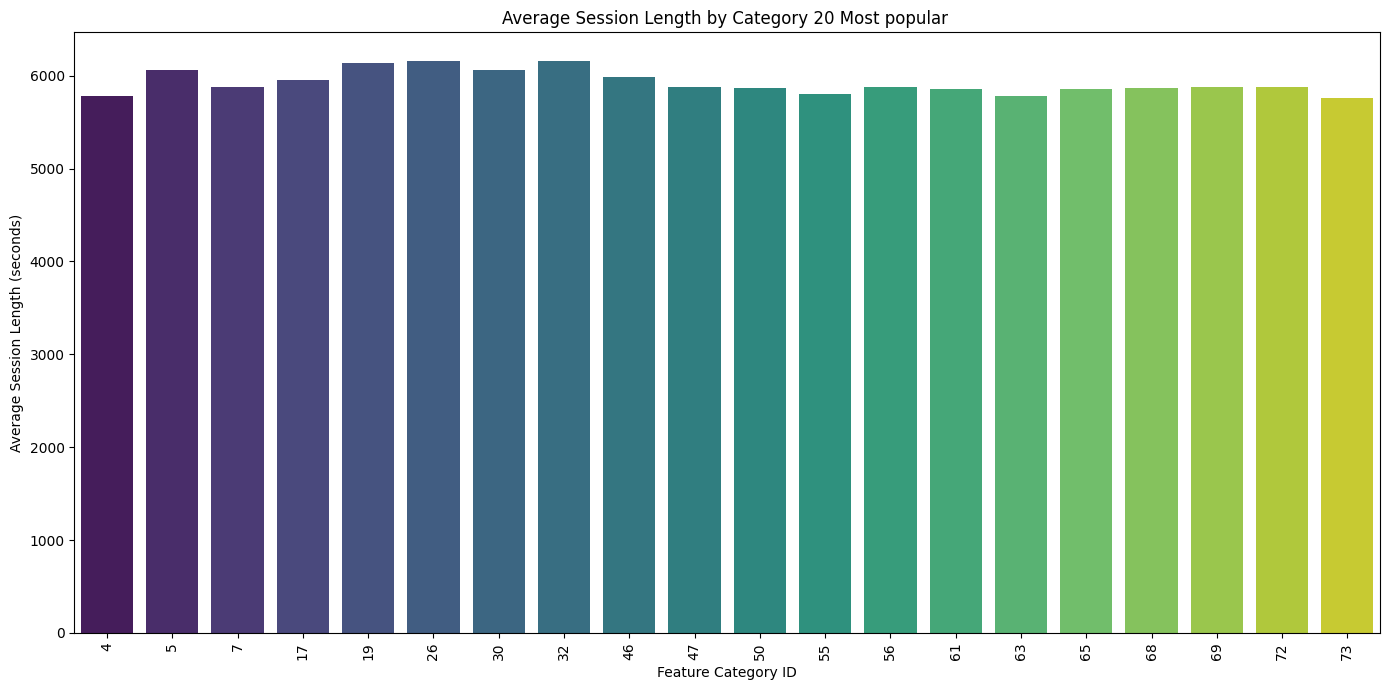

In [ ]:
top20_category_avg_session_length = category_avg_session_length[category_avg_session_length['feature_category_id'].isin(top_20.feature_category_id.unique())]
plt.figure(figsize=(14, 7))
sns.barplot(data=top20_category_avg_session_length, x='feature_category_id', y='session_length', palette='viridis')
plt.title('Average Session Length by Category 20 Most popular ')
plt.xlabel('Feature Category ID')
plt.ylabel('Average Session Length (seconds)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if needed
plt.tight_layout()
plt.show()